# Evaluation des performances de différents modèles

## Import lib et data

In [2]:
# Classique
import pandas as pd
import numpy as np
import re
import joblib
import time
import random
from collections import Counter

# Lime
from lime import lime_tabular

# Visu
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
pd.set_option('display.max_columns', None)

# utils
import utils

# MLFlow
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn

# SKlearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    StratifiedKFold, LearningCurveDisplay
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, \
                            precision_score, recall_score, make_scorer, \
                            average_precision_score, f1_score, fbeta_score, \
                            accuracy_score
from sklearn.linear_model import LogisticRegression

# ImbLearn (SMOTE)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline, Pipeline

# LightGBM
from lightgbm import LGBMClassifier

---

## Séparation des données

In [3]:
train_df = pd.read_csv('Data/train.csv')
feats = [f for f in train_df.columns if f not in 
         ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df[feats]
y = train_df['TARGET']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    train_size = 0.8,
                                                    random_state = 42)

In [5]:
print('Shape of training set')
print('X_train : {}'.format(X_train.shape))
print('y_train : {}'.format(y_train.shape))
print('ratio TARGET : ', y_train.value_counts(normalize=True).values)
print('------------------------')
print('Shape of test set')
print('X_test : {}'.format(X_test.shape))
print('y_test : {}'.format(y_test.shape))
print('ratio TARGET : ',y_test.value_counts(normalize=True).values)

Shape of training set
X_train : (245990, 98)
y_train : (245990,)
ratio TARGET :  [0.91927314 0.08072686]
------------------------
Shape of test set
X_test : (61498, 98)
y_test : (61498,)
ratio TARGET :  [0.91926567 0.08073433]


In [6]:
idx = random.randint(1, len(X_test))
data_test = X_train.iloc[[idx]]
data_test.to_csv('flask_application/data_test.csv')

## Pré-traitement des données

### Imputations et Scaling

In [7]:
num_features = make_column_selector(dtype_include = ['float64'])

pipe_num = Pipeline([
    ("impnum", SimpleImputer()),
    ("sc", StandardScaler()),
])

cat_features = make_column_selector(dtype_exclude = ['float64'])
pipe_cat = Pipeline([
    ("impcat", SimpleImputer(strategy = 'most_frequent'))
])

preprocessor = make_column_transformer((pipe_num, num_features),
                                       (pipe_cat, cat_features))


### Traitement désequilibre des classes

In [8]:
over_sampler = SMOTE(random_state=42)

under_sampler = RandomUnderSampler(random_state=42)

## Définition des scores utilisés pour évaluer nos modèles

In [9]:
scoring = {'AUC' : 'roc_auc',
           'AP_score' : make_scorer(average_precision_score,needs_proba=True),
           'f1_score' : 'f1',
           'f10_score' : make_scorer(fbeta_score, beta=10),
           'accuracy' : 'accuracy'
          }

# Logistic Regression

## Sélection hyperparamètres avec GridSearch

In [10]:
pipeline = Pipeline([
    ('imputer_scaler', preprocessor),
    ('over', over_sampler),
    ('under', under_sampler),
    ('estimator',  LogisticRegression(tol=0.1))
])

param_grid = {
    "estimator__C": [0.001, 0.002],
    "estimator__max_iter": [200, 300],
    "estimator__solver": ["newton-cholesky", 'lbfgs'],
    "over__sampling_strategy": [0.1, 0.2, 0.5]
}

cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit='f10_score')

In [11]:
print('Entrainement du modèle...')
start = time.time()
grid.fit(X_train, y_train)
end = time.time()
delta = round((end - start), 3)
print('Temps total CV : {}s'.format(delta))

Entrainement du modèle...
Temps total CV : 458.129s


## Evaluation du modèle

In [12]:
b_score = grid.best_score_
b_params = grid.best_params_
print('Résultat sur le jeu d\'entrainement avec cross-validation')
print('Meilleur score : {}'.format(b_score))
print('Meilleur params : {}'.format(b_params))

Résultat sur le jeu d'entrainement avec cross-validation
Meilleur score : 0.6228078591397935
Meilleur params : {'estimator__C': 0.002, 'estimator__max_iter': 200, 'estimator__solver': 'newton-cholesky', 'over__sampling_strategy': 0.2}


In [13]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__max_iter,param_estimator__solver,param_over__sampling_strategy,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_AP_score,split1_test_AP_score,split2_test_AP_score,split3_test_AP_score,split4_test_AP_score,mean_test_AP_score,std_test_AP_score,rank_test_AP_score,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,split3_test_f1_score,split4_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_test_f10_score,split1_test_f10_score,split2_test_f10_score,split3_test_f10_score,split4_test_f10_score,mean_test_f10_score,std_test_f10_score,rank_test_f10_score,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,2.754892,0.208751,0.477849,0.068117,0.001,200,newton-cholesky,0.1,"{'estimator__C': 0.001, 'estimator__max_iter':...",0.689067,0.682740,0.689936,0.693394,0.682278,0.687483,0.004314,13,0.161183,0.153072,0.154942,0.161848,0.150711,0.156351,0.004430,21,0.221854,0.219492,0.222742,0.222664,0.220459,0.221442,0.001274,15,0.618248,0.609399,0.623969,0.625560,0.610548,0.617545,0.006653,13,0.636835,0.637160,0.635148,0.633989,0.638481,0.636323,0.001578,13
1,2.793062,0.184225,0.457673,0.027879,0.001,200,newton-cholesky,0.2,"{'estimator__C': 0.001, 'estimator__max_iter':...",0.688961,0.684726,0.687767,0.694814,0.682389,0.687731,0.004225,11,0.161404,0.154680,0.154332,0.163540,0.151169,0.157025,0.004662,15,0.220602,0.221060,0.222683,0.225417,0.218990,0.221750,0.002178,11,0.616909,0.615833,0.624876,0.631488,0.606654,0.619152,0.008452,9,0.634904,0.636591,0.634457,0.636388,0.637689,0.636006,0.001178,19
2,3.175920,0.334705,0.448960,0.021733,0.001,200,newton-cholesky,0.5,"{'estimator__C': 0.001, 'estimator__max_iter':...",0.685867,0.684065,0.684136,0.693341,0.681291,0.685740,0.004073,23,0.160498,0.155372,0.152890,0.163604,0.151183,0.156709,0.004665,19,0.217301,0.221659,0.221058,0.224527,0.219480,0.220805,0.002395,21,0.608374,0.616154,0.619354,0.627683,0.606728,0.615659,0.007633,19,0.632912,0.637709,0.634294,0.636774,0.638725,0.636083,0.002161,17
3,2.802014,0.225221,0.470998,0.056483,0.001,200,lbfgs,0.1,"{'estimator__C': 0.001, 'estimator__max_iter':...",0.688908,0.682605,0.689563,0.693346,0.682199,0.687324,0.004297,15,0.161061,0.152940,0.154651,0.161544,0.150551,0.156149,0.004407,23,0.221437,0.219209,0.222299,0.222462,0.219783,0.221038,0.001319,19,0.616350,0.608438,0.622984,0.624613,0.607692,0.616015,0.007061,17,0.637099,0.637140,0.634782,0.634131,0.638786,0.636388,0.001703,11
4,3.111147,0.152799,0.474471,0.054520,0.001,200,lbfgs,0.2,"{'estimator__C': 0.001, 'estimator__max_iter':...",0.689236,0.684893,0.687792,0.695634,0.682823,0.688075,0.004388,9,0.161553,0.154758,0.154260,0.163576,0.151263,0.157082,0.004677,13,0.221235,0.221308,0.222888,0.226689,0.219123,0.222249,0.002522,9,0.616777,0.613806,0.622387,0.633519,0.606445,0.618587,0.009066,11,0.636388,0.638400,0.636449,0.637912,0.638115,0.637453,0.000859,5
5,4.234923,0.299785,0.447382,0.031642,0.001,200,lbfgs,0.5,"{'estimator__C': 0.001, 'estimator__max_iter':...",0.686602,0.684246,0.684343,0.694576,0.681347,0.686223,0.004497,19,0.161043,0.155218,0.153029,0.163693,0.151306,0.156858,0.004742,17,0.218049,0.222154,0.221418,0.225902,0.220171,0.221539,0.002588,13,0.607343,0.614394,0.615971,0.627436,0.605225,0.614074,0.007821,21,0.635249,0.639884,0.637201,0.639904,0.641185,0.638684,0.002153,1
6,2.775786,0.143569,0.465190,0.025188,0.001,300,newton-cholesky,0.1,"{'estimator__C': 0.001, 'estimator__max_iter':...",0.689067,0.682740,0.689936,0.693394,0.682278,0.687483,0.004314,13,0.161183,0.153072,0.154942,0.161848,0.150711,0.156351,0.004430,21,0.221854,0.219492,0.222742,0.222664,0.220459,0.221442,0.001274,15,0.618248,0.609399,0.623969,0.625560,0.610548,0.617545,0.006653,13,0.636835,0.63

Résultat sur le jeu de test avec le meilleur modèle retenu


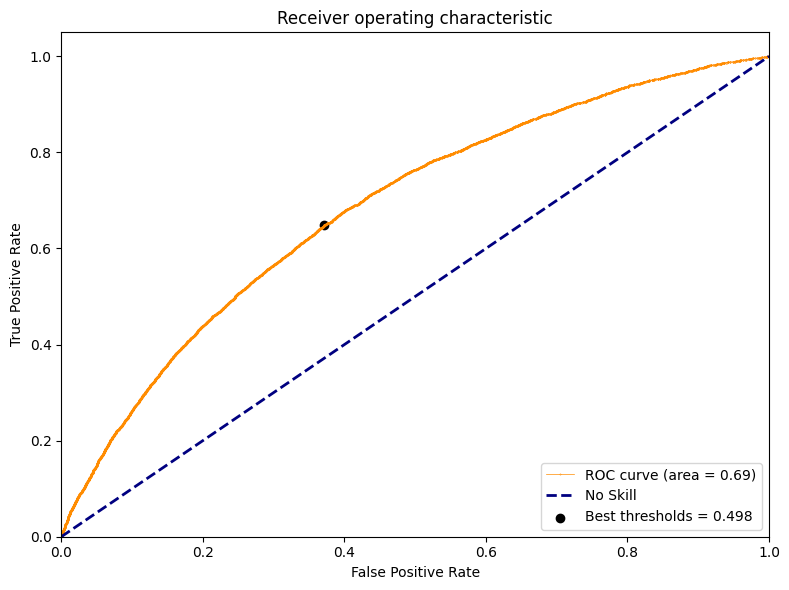

Fbeta score (beta=10), seuil=0.5 : 0.6196366640727825
Fbeta score (beta=10), seuil=0.498 : 0.6247498665314698


In [14]:
predictions = grid.predict_proba(X_test)[:, 1]
preds = grid.predict(X_test)

print('Résultat sur le jeu de test avec le meilleur modèle retenu')
best_thresh = utils.plot_roc_auc(y_test, predictions)

preds_threshed = (grid.predict_proba(X_test)[:, 1] > best_thresh).astype(int)

print('Fbeta score (beta=10), seuil=0.5 : {}'.format(
    fbeta_score(y_test, preds, beta=10)))
print('Fbeta score (beta=10), seuil={} : {}'.format(
    round(best_thresh, 3), fbeta_score(y_test, preds_threshed, beta=10)))

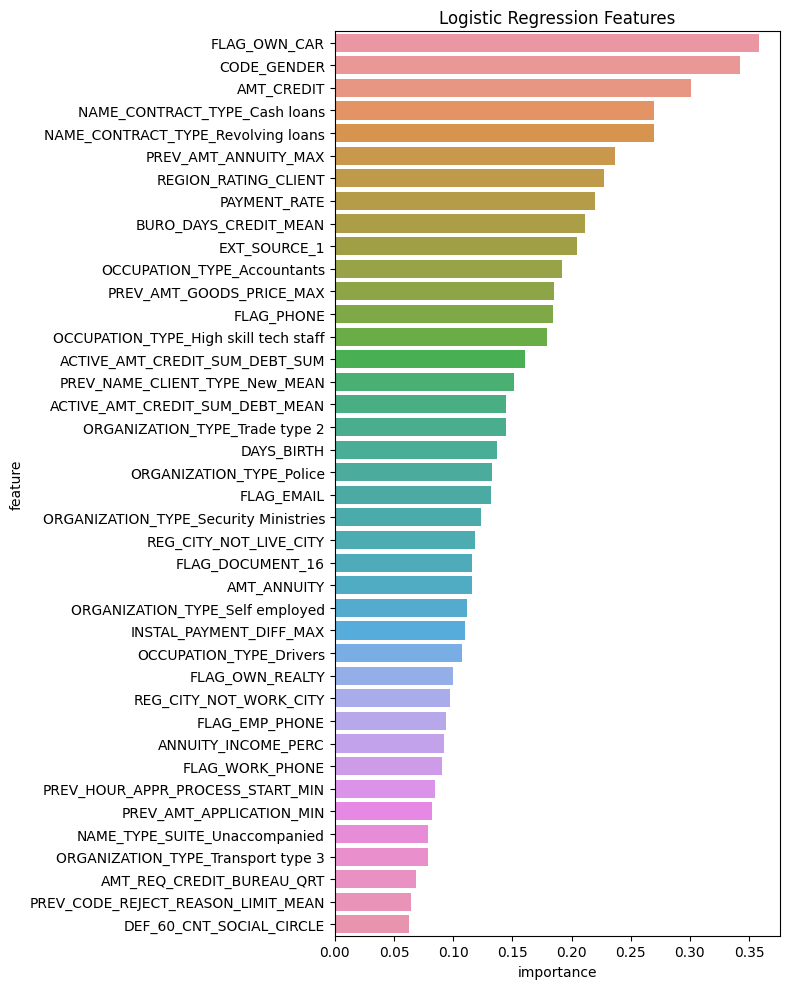

In [56]:
importance_df = pd.DataFrame()

names = grid.best_estimator_.named_steps['imputer_scaler'].get_feature_names_out()
feature_names = []
for name in names:
    name1 = name.replace('pipeline-1__', '')
    name2 = name1.replace('pipeline-2__', '')
    feature_names.append(name2)

importance_df["feature"] = feature_names
importance_df["importance"] = np.abs(grid.best_estimator_['estimator'].coef_[0])

title = 'Logistic Regression Features'
utils.display_importances(importance_df, title)

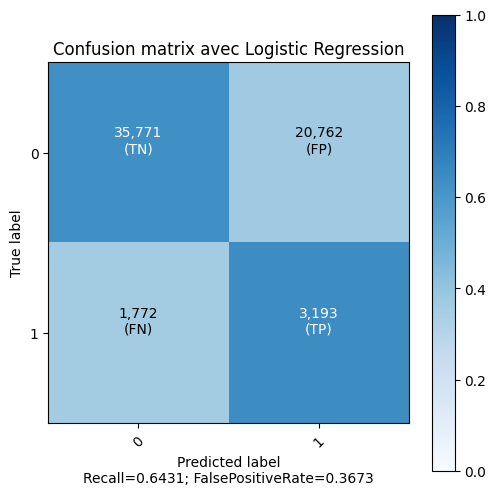

In [16]:
cm = confusion_matrix(y_test, preds)
title = 'Confusion matrix avec Logistic Regression'
utils.plot_confusion_matrix(cm, ['0', '1'], title, normalize=True)

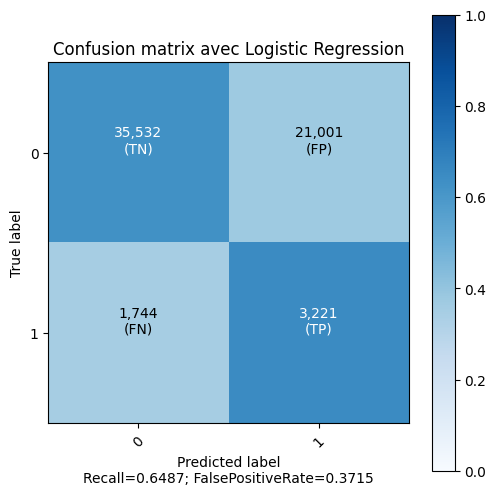

In [17]:
cm = confusion_matrix(y_test, preds_threshed)
title = 'Confusion matrix avec Logistic Regression'
utils.plot_confusion_matrix(cm, ['0', '1'], title, normalize=True)

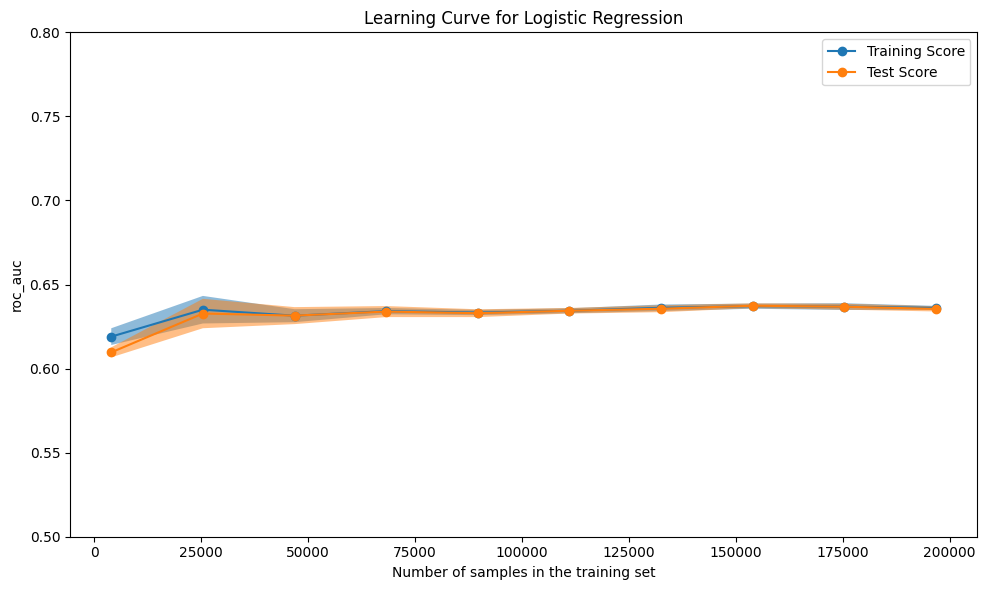

In [18]:
utils.plot_learning_curve(X_train, y_train, grid.best_estimator_)

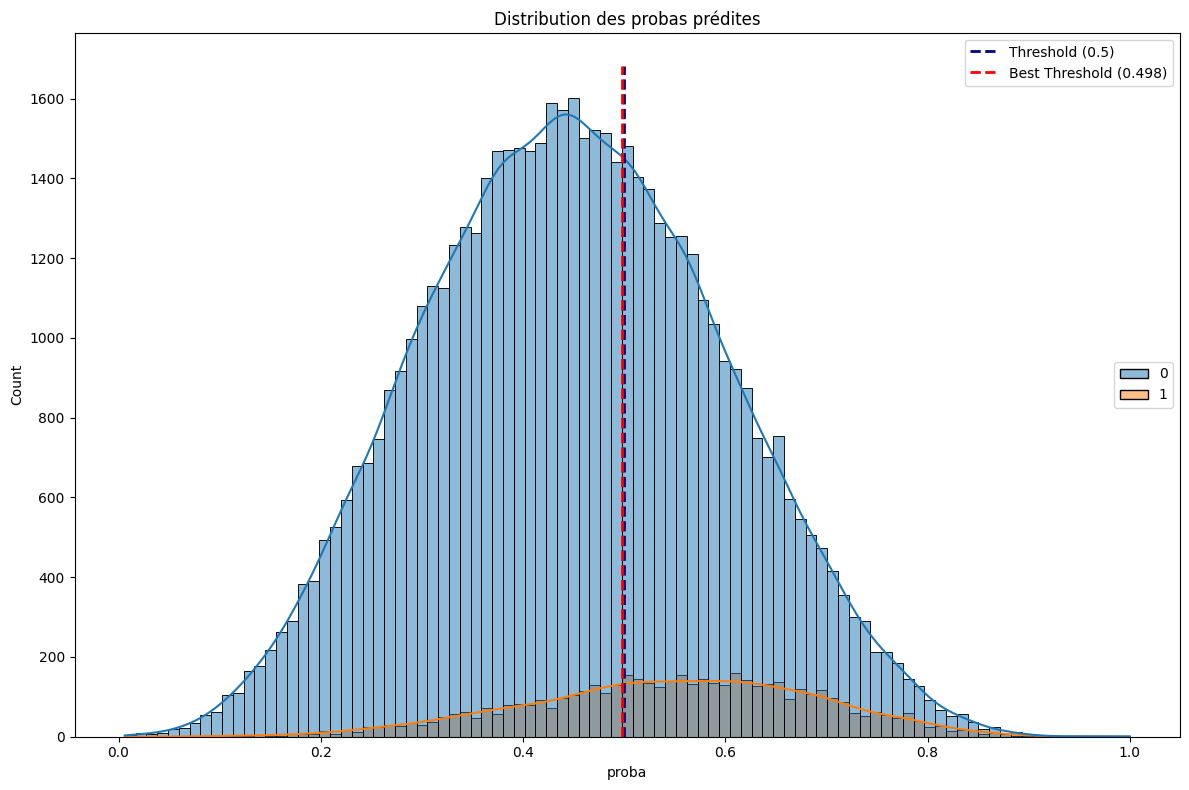

In [20]:
utils.plot_hist_proba(predictions, y_test, best_thresh)

## Enregistrement params/metrics/artefacts avec MLFlow

In [15]:
# avant cela nous allons reconstruire le dataset pour savoir le train et le test
def artifact_df(X_training, y_training, X_test, y_test, feats):
    df_train = pd.DataFrame(X_training, columns=feats)
    df_train['target'] = y_training
    df_train.to_csv('train_data.csv')

    df_test = pd.DataFrame(X_test, columns=feats)
    df_test['target'] = y_test
    df_test.to_csv('test_data.csv')

    return None

In [16]:
# Création d'une fonction personnalisée pour effectuer des prédictions en fonction d'un seuil
class CustomModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model, threshold=0.5):
        self.model = model
        self.threshold = threshold

    def predict(self, context, model_input):
        # Prédiction personnalisée avec le paramètre threshold
        probabilities = self.model.predict_proba(model_input)
        predictions = (probabilities[:, 1] >= self.threshold).astype(int)
        return predictions
    
    def predict_proba(self, context, model_input):
        return self.model.predict_proba(model_input)

C:\Users\julie\anaconda3\lib\site-packages\mlflow\models\signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


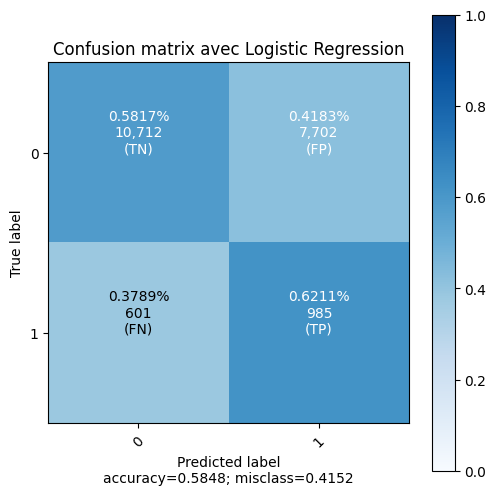

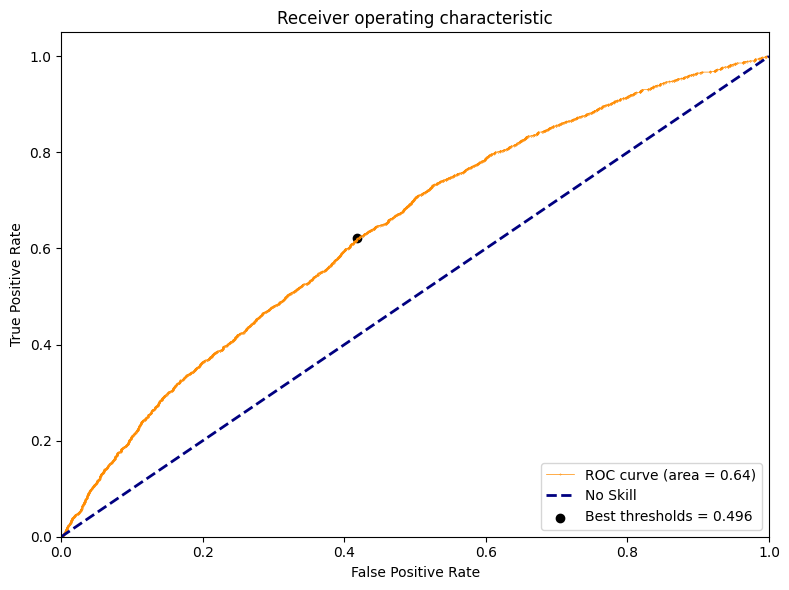

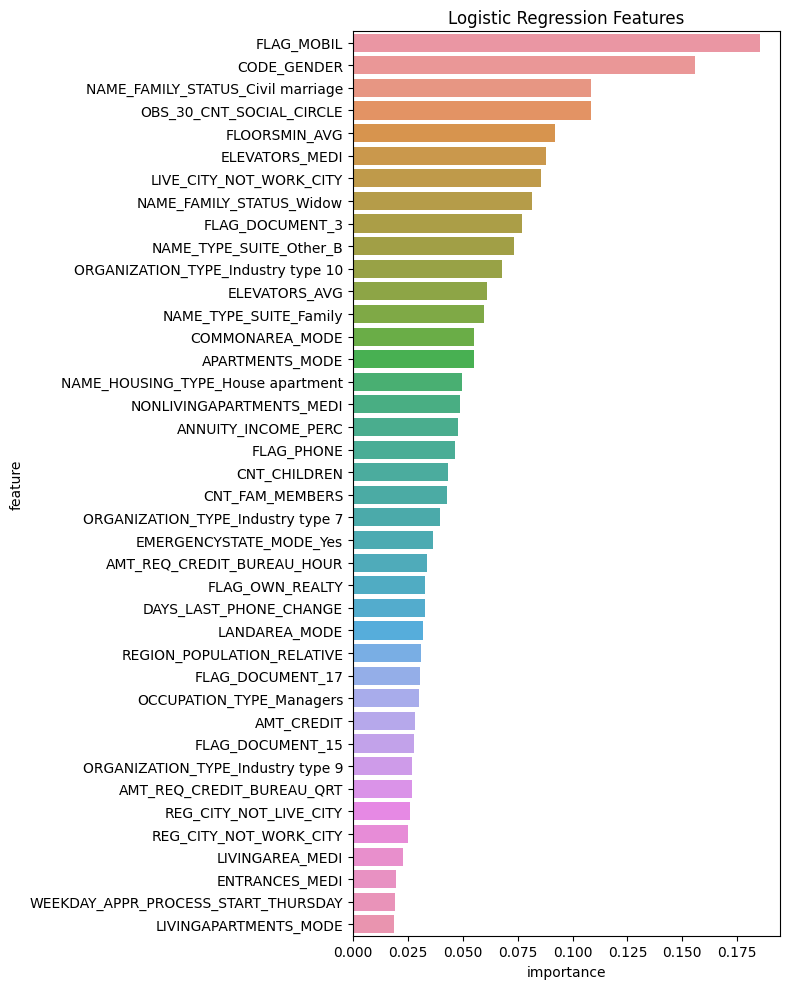

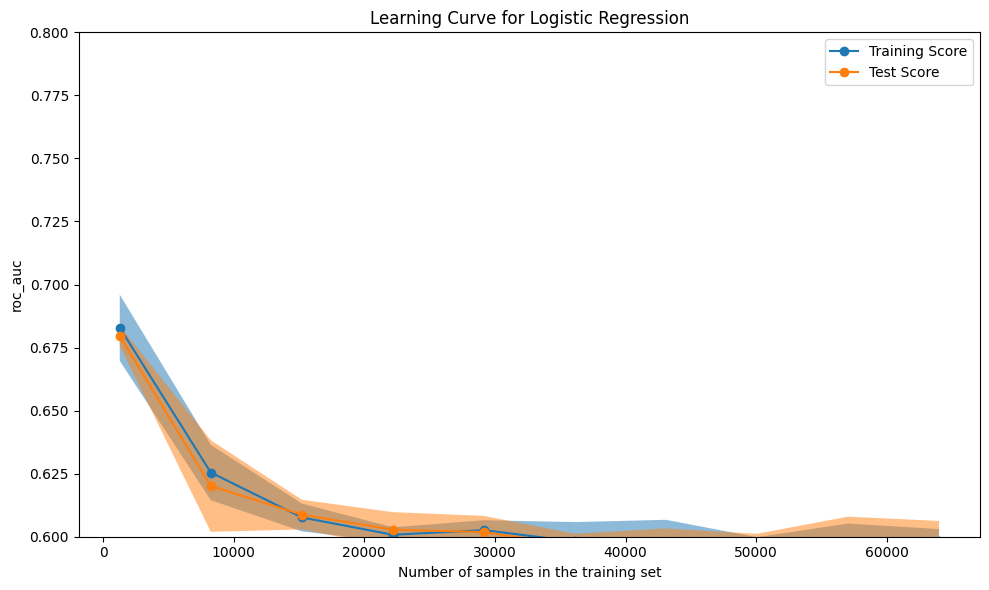

In [22]:
run_description = """
### Data
30% du dataset total (en terme de client)
Sélection de feature : condition sur la variance
                       Kbest (k=100) basé sur mutual_info_classif
Imputation simple : float --> mean
                    int   --> most frequent
Standard scaler pour vars continues

### Modèle
logistic regression paramétrer avec GridSearchCV
Threshold adapté au problème (cout FN = 10 * cout FP)
"""
run_name = 'LogisticRegressionThresholded'

with mlflow.start_run(run_name=run_name, description=run_description):

    # Enregistrement de plusieurs paramètres sous forme d'un dictionnaire
    params = {}
    params['MODEL_NAME'] = 'LogisticRegression'
    params['PARAMS_CV'] = b_params
    params['THRESHOLD'] = best_thresh
    params['BETA'] = 10
    params['TRAIN_SIZE'] = len(X_train)
    params['TEST_SIZE'] = len(X_test)
    params['SEED'] = 42
    mlflow.log_params(params)

    # On note le moment du début de l'expérience pour mesurer la durée de l'entraînement
    start = time.time()

    # Initialisation du modèle
    params = dict(**b_params)
    pred_pipeline = Pipeline([
        ('imputer_scaler', preprocessor),
        ('smote', sampler),
        ('estimator',  LogisticRegression(tol=0.1))
    ])
    pred_pipeline.set_params(**params)
    signature = infer_signature(X_train, y_train)

    # Entraînement du modèle
    pred_pipeline.fit(X_train, y_train)

    training_time = time.time() - start

    # # Enregistrement du modèle
    
    # Appliquez le seuil de prédiction souhaité avec votre fonction personnalisée
    custom_threshold = best_thresh  # Définissez ici la valeur de threshold souhaitée
    custom_model = CustomModelWrapper(pred_pipeline, threshold=custom_threshold)
    
    predictions = custom_model.predict(None, X_test)
    predictions_proba = pred_pipeline.predict_proba(X_test)[:, 1]

    # Enregistrez le modèle avec le seuil ajusté dans MLflow
    mlflow.pyfunc.log_model(
    python_model=custom_model,  
    artifact_path="mlflow_LR_with_threshold",  
    signature=signature
    )
    
    # Enregistrement du modèle avec joblib
    joblib.dump(pred_pipeline, 'flask_application/model.joblib')

    # Enregistrement de plusieurs métriques sous forme d'un dictionnaire
    metrics = {}
    metrics['Auc'] = roc_auc_score(y_test, predictions_proba)
    metrics['Fbeta'] = fbeta_score(y_test, predictions, beta=10)
    metrics['Precision'] = precision_score(y_test, predictions)
    metrics['Recall'] = recall_score(y_test, predictions)
    metrics['Accuracy'] = accuracy_score(y_test, predictions)
    metrics['Training Time'] = training_time
    mlflow.log_metrics(metrics)

    # Enregistrement de la matrice de confusion
    cm = confusion_matrix(y_test, predictions)
    title = 'Confusion matrix avec Logistic Regression'
    utils.plot_confusion_matrix(cm, ['0', '1'], title)
    mlflow.log_artifact('Data/matrix.png')

    # Enregistrement courbe ROC
    utils.plot_roc_auc(y_test, predictions_proba)
    mlflow.log_artifact('Data/roc_auc_curve.png')

    # Enregistrement features importance du modèle
    importance_df = pd.DataFrame()
    importance_df["feature"] = feats
    importance_df["importance"] = np.abs(pred_pipeline['estimator'].coef_[0])

    title = 'Logistic Regression Features'
    utils.display_importances(importance_df, title)
    mlflow.log_artifact('Data/features_importances.png')

    # Enregistrement Learning curve
    utils.plot_learning_curve(X_train, y_train, pred_pipeline)
    mlflow.log_artifact('Data/learning_curve.png')
    
    # # Enregistrement des datasets train et test
    # artifact_df(X_train, y_train, X_test, y_test, feats)
    # mlflow.log_artifact('train_data.csv')
    # mlflow.log_artifact('test_data.csv')
      

## Feature importance with LIME

In [61]:
cat_features = [i for i, c in enumerate(X.columns) if X.dtypes[i]!='float64']
class_names = ['accordé', 'refusé']

X_smpl = X.sample(10000)
X_smpl_tr = grid.best_estimator_.named_steps['imputer_scaler'].transform(X_smpl)

lime_data = pd.DataFrame(X_smpl_tr, columns=feature_names)
lime_data.to_csv('flask_application/lime_data.csv', index=False)

explainer = lime_tabular.LimeTabularExplainer(X_smpl_tr, mode="classification",
                                              class_names=class_names,
                                              feature_names=feature_names,
                                              categorical_features=cat_features
                                             )

In [63]:
idx = random.randint(1, len(X_test))

X_test_tr = grid.best_estimator_.named_steps['imputer_scaler'].transform(X_test.iloc[[idx]])
predict_fn = grid.best_estimator_.named_steps['estimator'].predict_proba

pred = (grid.predict_proba(X_test.iloc[[idx]])[0][1] > best_thresh).astype(int)
print("Prediction : ", class_names[pred])
print("True :     ", class_names[int(y_test.iloc[idx])])

explanation = explainer.explain_instance(X_test_tr[0], predict_fn,
                                         num_features=15)

explanation.show_in_notebook()

Prediction :  refusé
True :      accordé


KeyError: "['WEEKDAY_APPR_PROCESS_START_SUNDAY'] not in index"

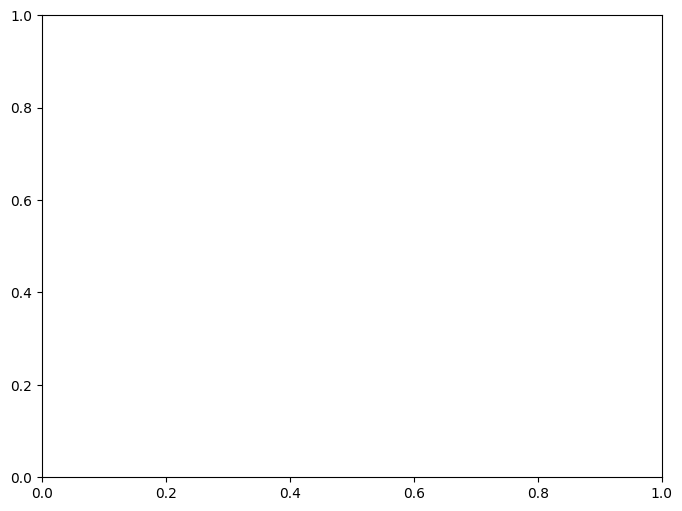

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

data = train_df[['WEEKDAY_APPR_PROCESS_START_SUNDAY', 'TARGET']]
sns.histplot(data=data, ax=ax, x='WEEKDAY_APPR_PROCESS_START_SUNDAY', hue='TARGET', multiple='dodge', discrete=True, shrink=0.5)
ax.set_xticks([0, 1])

a = [p.get_height() for p in ax.patches]
pourcentage = [a[0]/(a[0] + a[2]), a[1]/(a[1] + a[3]), a[2]/(a[0] + a[2]), a[3]/(a[1] + a[3])]
pourcentage = [np.round(100*i, 2) for i in pourcentage]

for i, p in enumerate(ax.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
     
    plt.text(x+width/2,
             y+height*1.01,
             str(pourcentage[i])+'%',
             ha='center',
             weight='bold')
    
# pouvoir choisir quelle variable plot, et sur quel jeu de donnée (tout ou un cluster lié au client)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

data = train_df[['DAYS_EMPLOYED_PERC', 'TARGET']]
sns.histplot(data=data, ax=ax, x='DAYS_EMPLOYED_PERC', hue='TARGET', multiple='stack', kde=True)
#ax.set_xlim(0, 100)

In [ ]:
coefs = grid.best_estimator_['estimator'].coef_[0]
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(10,16))
    plt.barh(range(len(coefs)), coefs, color=["red" if coef<0 else "green" for coef in coefs])
    plt.yticks(range(len(coefs)), X.columns);
    plt.title("Weights")

# Light Gradient Boosting Model (LGBM)

## Sélection hyperparamètres avec GridSearch

In [20]:
def custom_scorer(y_true, y_proba):
    th = 0.085
    y_pred = (y_proba > th).astype(int)
    return 'f10', fbeta_score(y_true, y_pred, beta=10), True

In [58]:
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train,
                                      stratify=y_train,
                                      train_size = 0.8,
                                      random_state = 42)

In [59]:
param_grid = {
    'n_estimators': [5000],
    'learning_rate': [0.02],
    'scale_pos_weight': [1, 5, 10]
}

param_fit = {
    'early_stopping_rounds': 200,
    'eval_metric': 'auc',
    'eval_set' : [(X_v, y_v)],
    'verbose': 100
}
    

clf = LGBMClassifier(
    max_depth=8,
    num_leaves=31,
    colsample_bytree=0.85,
    subsample=0.8715623,
    subsample_freq=5,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.05,
    min_child_weight=39.3259775
)

cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, scoring=scoring, refit='f10_score')

In [60]:
print('Entrainement du modèle...')
start = time.time()
grid.fit(X_t, y_t, **param_fit)
end = time.time()
delta = round((end - start), 3)
print('Temps total CV : {}s'.format(delta))

Entrainement du modèle...


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.713025	valid_0's binary_logloss: 0.261503
[200]	valid_0's auc: 0.726596	valid_0's binary_logloss: 0.25649
[300]	valid_0's auc: 0.732236	valid_0's binary_logloss: 0.254439
[400]	valid_0's auc: 0.735649	valid_0's binary_logloss: 0.253223
[500]	valid_0's auc: 0.737989	valid_0's binary_logloss: 0.252408
[600]	valid_0's auc: 0.73955	valid_0's binary_logloss: 0.251957
[700]	valid_0's auc: 0.740411	valid_0's binary_logloss: 0.251661
[800]	valid_0's auc: 0.741022	valid_0's binary_logloss: 0.251431
[900]	valid_0's auc: 0.741501	valid_0's binary_logloss: 0.251257
[1000]	valid_0's auc: 0.741879	valid_0's binary_logloss: 0.251129
[1100]	valid_0's auc: 0.742277	valid_0's binary_logloss: 0.250995
[1200]	valid_0's auc: 0.742471	valid_0's binary_logloss: 0.250908
[1300]	valid_0's auc: 0.742761	valid_0's binary_logloss: 0.250805
[1400]	valid_0's auc: 0.742865	valid_0's binary_logloss: 0.250765
[1500]	valid_0's auc: 0.742786	valid_0's binary_logloss: 0.250798
[1600]	valid_0's auc:

C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.71339	valid_0's binary_logloss: 0.261363
[200]	valid_0's auc: 0.725921	valid_0's binary_logloss: 0.256649
[300]	valid_0's auc: 0.730957	valid_0's binary_logloss: 0.254699
[400]	valid_0's auc: 0.73463	valid_0's binary_logloss: 0.253506
[500]	valid_0's auc: 0.73682	valid_0's binary_logloss: 0.252739
[600]	valid_0's auc: 0.738436	valid_0's binary_logloss: 0.252208
[700]	valid_0's auc: 0.739781	valid_0's binary_logloss: 0.251813
[800]	valid_0's auc: 0.739701	valid_0's binary_logloss: 0.251742
[900]	valid_0's auc: 0.740405	valid_0's binary_logloss: 0.251521
[1000]	valid_0's auc: 0.740224	valid_0's binary_logloss: 0.251511
[1100]	valid_0's auc: 0.740304	valid_0's binary_logloss: 0.251448


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.71529	valid_0's binary_logloss: 0.261067
[200]	valid_0's auc: 0.726122	valid_0's binary_logloss: 0.256479
[300]	valid_0's auc: 0.731785	valid_0's binary_logloss: 0.254387
[400]	valid_0's auc: 0.735414	valid_0's binary_logloss: 0.253147
[500]	valid_0's auc: 0.737731	valid_0's binary_logloss: 0.252389
[600]	valid_0's auc: 0.739375	valid_0's binary_logloss: 0.251848
[700]	valid_0's auc: 0.740379	valid_0's binary_logloss: 0.251559
[800]	valid_0's auc: 0.740625	valid_0's binary_logloss: 0.251473
[900]	valid_0's auc: 0.741081	valid_0's binary_logloss: 0.251307
[1000]	valid_0's auc: 0.741285	valid_0's binary_logloss: 0.251215
[1100]	valid_0's auc: 0.741732	valid_0's binary_logloss: 0.25108
[1200]	valid_0's auc: 0.741964	valid_0's binary_logloss: 0.251011
[1300]	valid_0's auc: 0.74212	valid_0's binary_logloss: 0.250988
[1400]	valid_0's auc: 0.742265	valid_0's binary_logloss: 0.250961
[1500]	valid_0's auc: 0.742079	valid_0's binary_logloss: 0.25097


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.71485	valid_0's binary_logloss: 0.261192
[200]	valid_0's auc: 0.72744	valid_0's binary_logloss: 0.256409
[300]	valid_0's auc: 0.732288	valid_0's binary_logloss: 0.254418
[400]	valid_0's auc: 0.735688	valid_0's binary_logloss: 0.253186
[500]	valid_0's auc: 0.737932	valid_0's binary_logloss: 0.252453
[600]	valid_0's auc: 0.739148	valid_0's binary_logloss: 0.252036
[700]	valid_0's auc: 0.740053	valid_0's binary_logloss: 0.251778
[800]	valid_0's auc: 0.740522	valid_0's binary_logloss: 0.25163
[900]	valid_0's auc: 0.741215	valid_0's binary_logloss: 0.251437
[1000]	valid_0's auc: 0.74121	valid_0's binary_logloss: 0.251398
[1100]	valid_0's auc: 0.741536	valid_0's binary_logloss: 0.251292
[1200]	valid_0's auc: 0.741223	valid_0's binary_logloss: 0.251354


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.714079	valid_0's binary_logloss: 0.261164
[200]	valid_0's auc: 0.725207	valid_0's binary_logloss: 0.256602
[300]	valid_0's auc: 0.730845	valid_0's binary_logloss: 0.254608
[400]	valid_0's auc: 0.734465	valid_0's binary_logloss: 0.253384
[500]	valid_0's auc: 0.736998	valid_0's binary_logloss: 0.252549
[600]	valid_0's auc: 0.738624	valid_0's binary_logloss: 0.252026
[700]	valid_0's auc: 0.739063	valid_0's binary_logloss: 0.251815
[800]	valid_0's auc: 0.739567	valid_0's binary_logloss: 0.251643
[900]	valid_0's auc: 0.739865	valid_0's binary_logloss: 0.251539
[1000]	valid_0's auc: 0.740219	valid_0's binary_logloss: 0.251417
[1100]	valid_0's auc: 0.740575	valid_0's binary_logloss: 0.251323
[1200]	valid_0's auc: 0.740693	valid_0's binary_logloss: 0.251291
[1300]	valid_0's auc: 0.740773	valid_0's binary_logloss: 0.251289


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.718691	valid_0's binary_logloss: 0.362858
[200]	valid_0's auc: 0.727994	valid_0's binary_logloss: 0.379028


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.718123	valid_0's binary_logloss: 0.363252
[200]	valid_0's auc: 0.728275	valid_0's binary_logloss: 0.379019


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.719759	valid_0's binary_logloss: 0.362632
[200]	valid_0's auc: 0.728046	valid_0's binary_logloss: 0.379005


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.720054	valid_0's binary_logloss: 0.362871
[200]	valid_0's auc: 0.728977	valid_0's binary_logloss: 0.37903


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.719987	valid_0's binary_logloss: 0.362329
[200]	valid_0's auc: 0.728999	valid_0's binary_logloss: 0.378605


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.717943	valid_0's binary_logloss: 0.501529
[200]	valid_0's auc: 0.727806	valid_0's binary_logloss: 0.54502


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.716768	valid_0's binary_logloss: 0.501757
[200]	valid_0's auc: 0.726203	valid_0's binary_logloss: 0.544842


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.718902	valid_0's binary_logloss: 0.500735
[200]	valid_0's auc: 0.726351	valid_0's binary_logloss: 0.54478


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.718784	valid_0's binary_logloss: 0.501237
[200]	valid_0's auc: 0.728218	valid_0's binary_logloss: 0.544202


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.718398	valid_0's binary_logloss: 0.50073
[200]	valid_0's auc: 0.727011	valid_0's binary_logloss: 0.544239


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.715247	valid_0's binary_logloss: 0.26115
[200]	valid_0's auc: 0.727308	valid_0's binary_logloss: 0.256443
[300]	valid_0's auc: 0.733993	valid_0's binary_logloss: 0.254106
[400]	valid_0's auc: 0.737921	valid_0's binary_logloss: 0.252758
[500]	valid_0's auc: 0.740161	valid_0's binary_logloss: 0.251946
[600]	valid_0's auc: 0.741934	valid_0's binary_logloss: 0.251347
[700]	valid_0's auc: 0.742581	valid_0's binary_logloss: 0.251106
[800]	valid_0's auc: 0.743246	valid_0's binary_logloss: 0.250881
[900]	valid_0's auc: 0.743819	valid_0's binary_logloss: 0.2507
[1000]	valid_0's auc: 0.744308	valid_0's binary_logloss: 0.250533
[1100]	valid_0's auc: 0.744672	valid_0's binary_logloss: 0.250426
[1200]	valid_0's auc: 0.744942	valid_0's binary_logloss: 0.250354
[1300]	valid_0's auc: 0.744778	valid_0's binary_logloss: 0.250362
Temps total CV : 201.92s


## Evaluation du modèle

In [61]:
b_score = grid.best_score_
b_params = grid.best_params_
print('Résultat sur le jeu d\'entrainement avec cross-validation')
print('Meilleur score : {}'.format(b_score))
print('Meilleur params : {}'.format(b_params))

Résultat sur le jeu d'entrainement avec cross-validation
Meilleur score : 0.010170596130406833
Meilleur params : {'learning_rate': 0.02, 'n_estimators': 5000, 'scale_pos_weight': 1}


In [62]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results

{'mean_fit_time': array([23.53040929,  4.65875044,  4.45299191]),
 'std_fit_time': array([2.94863664, 0.36627891, 0.31106168]),
 'mean_score_time': array([1.6946167 , 0.19188104, 0.1846869 ]),
 'std_score_time': array([0.22228033, 0.00386297, 0.00821443]),
 'param_learning_rate': masked_array(data=[0.02, 0.02, 0.02],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[5000, 5000, 5000],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_scale_pos_weight': masked_array(data=[1, 5, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.02,
   'n_estimators': 5000,
   'scale_pos_weight': 1},
  {'learning_rate': 0.02, 'n_estimators': 5000, 'scale_pos_weight': 5},
  {'learning_rate': 0.02, 'n_estimators': 5000, 'scale_pos_weight': 10}],
 'split0_test_AUC': array([0.75061238, 0.690388

Résultat sur le jeu de test avec le meilleur modèle retenu


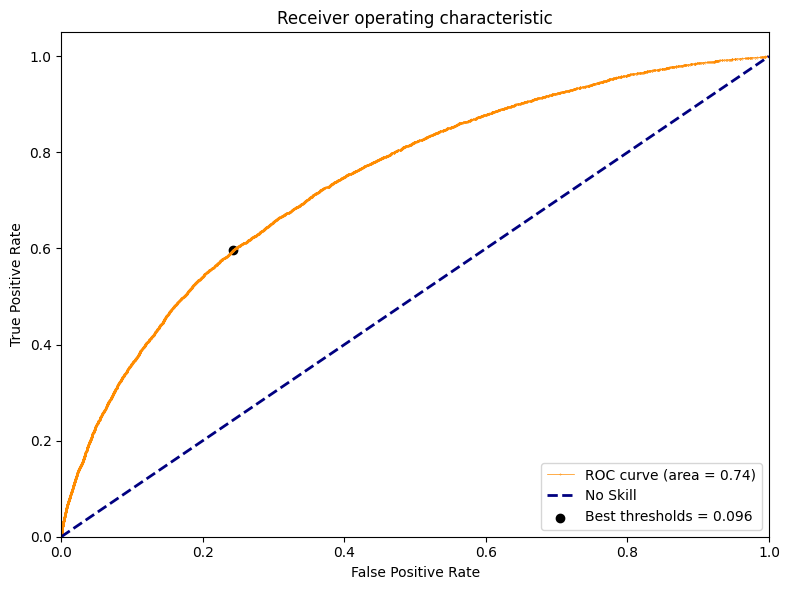

In [63]:
predictions = grid.predict_proba(X_test)[:, 1]

print('Résultat sur le jeu de test avec le meilleur modèle retenu')
best_thresh = utils.plot_roc_auc(y_test, predictions)

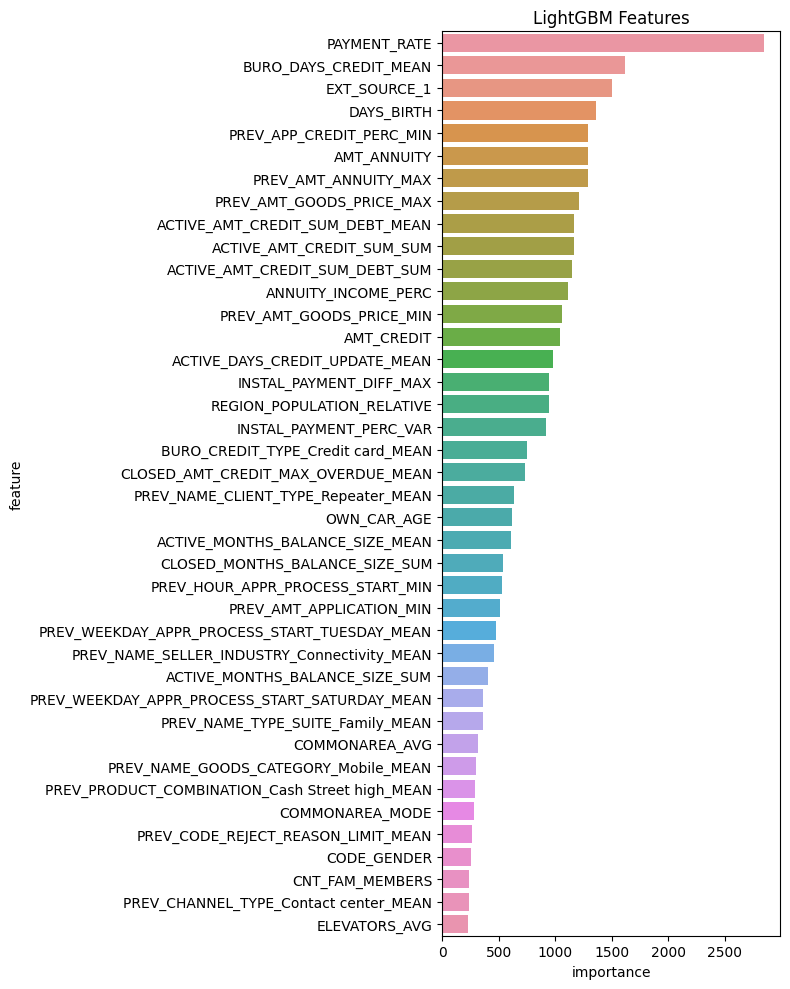

In [64]:
importance_df = pd.DataFrame()
importance_df["feature"] = feats
importance_df["importance"] = np.abs(grid.best_estimator_.feature_importances_)

title = 'LightGBM Features'
utils.display_importances(importance_df, title)

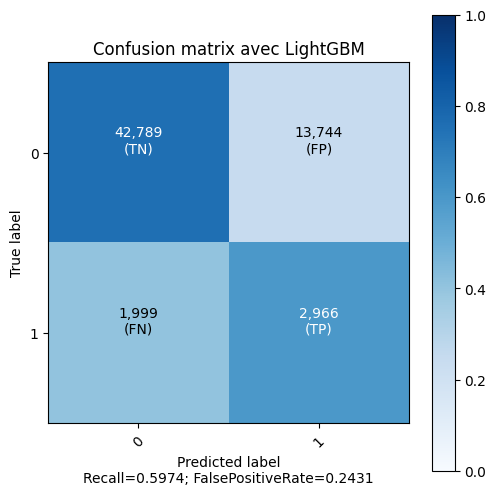

In [65]:
pred_threshed = []
for y in grid.predict_proba(X_test)[:, 1]:
    p = 0
    if y > best_thresh :
        p = 1
    pred_threshed.append(p)

        

cm = confusion_matrix(y_test, pred_threshed)
title = 'Confusion matrix avec LightGBM'
utils.plot_confusion_matrix(cm, ['0', '1'], title, normalize=True)